In [1]:
import torch
from torch import Tensor
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from matplotlib import pyplot as plt

from ebm.buffer import Buffer
from ebm.langevin_sampler import LangevinSampler, perform_langevin_chain
from ebm.trainer import EnergyModelTrainer, get_multi_class_cd_loss
from models.mlp import MLP
from utils.checkpoint import load_model
from utils.visualization import visualize_samples

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(42)

In [2]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]
)

# Download training data from open datasets.
training_data = datasets.MNIST(
    root='../data',
    train=True,
    download=True,
    transform=transform,
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root='../data',
    train=False,
    download=True,
    transform=transform,
)

n_class = len(datasets.MNIST.classes)

# Train/validation split
val_fraction = 0.1
dataset_size = len(training_data)
val_size = int(val_fraction * dataset_size)
train_size = dataset_size - val_size

# Create a reproducible shuffled list of indices
generator = torch.Generator().manual_seed(42)
indices = torch.randperm(dataset_size, generator=generator).tolist()

# Split indices for train and validation
train_indices = indices[:train_size]
val_indices = indices[train_size:]

# Wrap Subsets for train and validation datasets
train_data = Subset(training_data, train_indices)
val_data = Subset(training_data, val_indices)

batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

print(f"Training batches: {len(train_dataloader)}")
print(f"Test batches: {len(test_dataloader)}")

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64
Training batches: 469
Test batches: 79


In [4]:
def logits_to_energy(x: Tensor):
    return -x.exp().sum(axis=1).log()

In [5]:
model = MLP([784, 512, 512, n_class], device = device, flat=True)
buffer = Buffer(256, [1, 28, 28], 0.05, device)
sampler = LangevinSampler(model, 60, 10, 5e-3, buffer, logit_post_process_func=logits_to_energy)

In [6]:
model_save_path = '../models/ebm_multi_class.pth'
multi_class_cd_loss = get_multi_class_cd_loss(0)
trainer = EnergyModelTrainer(model,  5e-3, sampler, multi_class_cd_loss, device, 1e-4, 10, 10, model_save_path)

100%|██████████| 47/47 [00:02<00:00, 20.08it/s]


Epoch 1 completed. Train: loss: 1.1224, loss_cd: 0.1261, loss_clf: 0.9963, loss_reg: 0.0000, avg_energy_real: -6.2032, avg_energy_fake: -6.3293, avg_energy_rand: -2.2368
Val: loss: 0.9419, loss_cd: 0.3231, loss_clf: 0.6188, loss_reg: 0.0000, avg_energy_real: -7.4597, avg_energy_fake: -7.7828, avg_energy_rand: -2.2249# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 19.60it/s]


Epoch 2 completed. Train: loss: 0.6799, loss_cd: 0.1691, loss_clf: 0.5109, loss_reg: 0.0000, avg_energy_real: -7.7266, avg_energy_fake: -7.8957, avg_energy_rand: -2.2400
Val: loss: 0.8347, loss_cd: 0.3996, loss_clf: 0.4351, loss_reg: 0.0000, avg_energy_real: -7.8738, avg_energy_fake: -8.2734, avg_energy_rand: -2.2791# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 19.90it/s]


Epoch 3 completed. Train: loss: 0.5437, loss_cd: 0.1566, loss_clf: 0.3871, loss_reg: 0.0000, avg_energy_real: -7.9494, avg_energy_fake: -8.1060, avg_energy_rand: -2.3000
Val: loss: 0.7952, loss_cd: 0.4364, loss_clf: 0.3588, loss_reg: 0.0000, avg_energy_real: -7.9750, avg_energy_fake: -8.4114, avg_energy_rand: -2.3386# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 19.80it/s]


Epoch 4 completed. Train: loss: 0.4603, loss_cd: 0.1374, loss_clf: 0.3229, loss_reg: 0.0000, avg_energy_real: -8.0471, avg_energy_fake: -8.1845, avg_energy_rand: -2.3366
Val: loss: 0.8060, loss_cd: 0.4930, loss_clf: 0.3130, loss_reg: 0.0000, avg_energy_real: -8.0589, avg_energy_fake: -8.5519, avg_energy_rand: -2.3260(Best: 0.79522 at epoch 3)


100%|██████████| 47/47 [00:02<00:00, 20.45it/s]


Epoch 5 completed. Train: loss: 0.4034, loss_cd: 0.1227, loss_clf: 0.2807, loss_reg: 0.0000, avg_energy_real: -8.0977, avg_energy_fake: -8.2204, avg_energy_rand: -2.3412
Val: loss: 0.4387, loss_cd: 0.1700, loss_clf: 0.2687, loss_reg: 0.0000, avg_energy_real: -8.0750, avg_energy_fake: -8.2450, avg_energy_rand: -2.3615# NEW BEST MODEL #


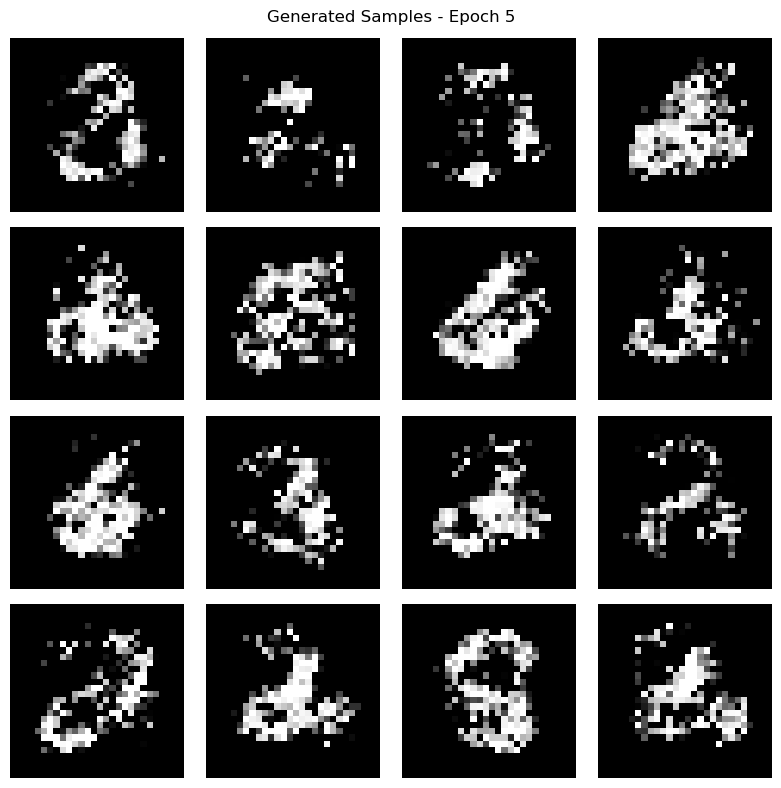

100%|██████████| 47/47 [00:02<00:00, 20.16it/s]


Epoch 6 completed. Train: loss: 0.3606, loss_cd: 0.1103, loss_clf: 0.2502, loss_reg: 0.0000, avg_energy_real: -8.1544, avg_energy_fake: -8.2648, avg_energy_rand: -2.3611
Val: loss: 0.4793, loss_cd: 0.2406, loss_clf: 0.2387, loss_reg: 0.0000, avg_energy_real: -8.2065, avg_energy_fake: -8.4471, avg_energy_rand: -2.3782(Best: 0.43871 at epoch 5)


100%|██████████| 47/47 [00:02<00:00, 19.52it/s]


Epoch 7 completed. Train: loss: 0.3264, loss_cd: 0.1008, loss_clf: 0.2256, loss_reg: 0.0000, avg_energy_real: -8.2316, avg_energy_fake: -8.3324, avg_energy_rand: -2.3834
Val: loss: 0.5193, loss_cd: 0.2991, loss_clf: 0.2202, loss_reg: 0.0000, avg_energy_real: -8.1839, avg_energy_fake: -8.4830, avg_energy_rand: -2.3691(Best: 0.43871 at epoch 5)


100%|██████████| 47/47 [00:02<00:00, 18.08it/s]


Epoch 8 completed. Train: loss: 0.2975, loss_cd: 0.0924, loss_clf: 0.2051, loss_reg: 0.0000, avg_energy_real: -8.2929, avg_energy_fake: -8.3854, avg_energy_rand: -2.3910
Val: loss: 0.5823, loss_cd: 0.3807, loss_clf: 0.2016, loss_reg: 0.0000, avg_energy_real: -8.3248, avg_energy_fake: -8.7055, avg_energy_rand: -2.4038(Best: 0.43871 at epoch 5)


100%|██████████| 47/47 [00:02<00:00, 20.46it/s]


Epoch 9 completed. Train: loss: 0.2751, loss_cd: 0.0874, loss_clf: 0.1877, loss_reg: 0.0000, avg_energy_real: -8.3830, avg_energy_fake: -8.4704, avg_energy_rand: -2.3979
Val: loss: 0.3620, loss_cd: 0.1787, loss_clf: 0.1833, loss_reg: 0.0000, avg_energy_real: -8.4420, avg_energy_fake: -8.6207, avg_energy_rand: -2.4059# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 21.12it/s]


Epoch 10 completed. Train: loss: 0.2549, loss_cd: 0.0813, loss_clf: 0.1736, loss_reg: 0.0000, avg_energy_real: -8.4320, avg_energy_fake: -8.5133, avg_energy_rand: -2.3912
Val: loss: 0.3253, loss_cd: 0.1541, loss_clf: 0.1712, loss_reg: 0.0000, avg_energy_real: -8.4882, avg_energy_fake: -8.6422, avg_energy_rand: -2.3988# NEW BEST MODEL #


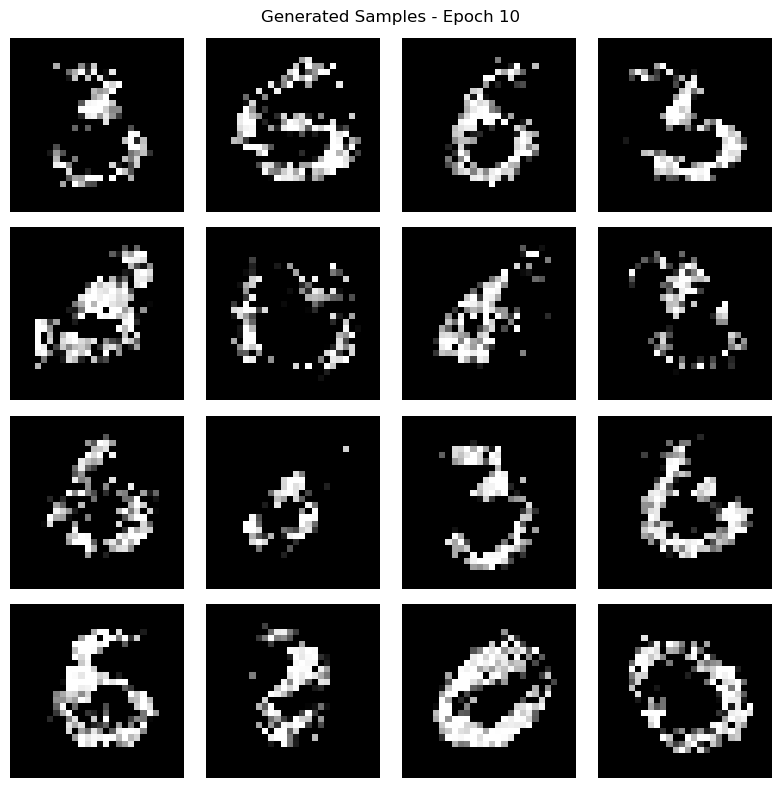

100%|██████████| 47/47 [00:02<00:00, 19.27it/s]


Epoch 11 completed. Train: loss: 0.2376, loss_cd: 0.0756, loss_clf: 0.1620, loss_reg: 0.0000, avg_energy_real: -8.5060, avg_energy_fake: -8.5816, avg_energy_rand: -2.3780
Val: loss: 0.4251, loss_cd: 0.2639, loss_clf: 0.1612, loss_reg: 0.0000, avg_energy_real: -8.5605, avg_energy_fake: -8.8244, avg_energy_rand: -2.3701(Best: 0.32533 at epoch 10)


100%|██████████| 47/47 [00:02<00:00, 19.39it/s]


Epoch 12 completed. Train: loss: 0.2243, loss_cd: 0.0728, loss_clf: 0.1515, loss_reg: 0.0000, avg_energy_real: -8.5659, avg_energy_fake: -8.6387, avg_energy_rand: -2.3622
Val: loss: 0.4466, loss_cd: 0.2924, loss_clf: 0.1542, loss_reg: 0.0000, avg_energy_real: -8.6010, avg_energy_fake: -8.8934, avg_energy_rand: -2.3375(Best: 0.32533 at epoch 10)


100%|██████████| 47/47 [00:02<00:00, 18.47it/s]


Epoch 13 completed. Train: loss: 0.2100, loss_cd: 0.0677, loss_clf: 0.1423, loss_reg: 0.0000, avg_energy_real: -8.6413, avg_energy_fake: -8.7090, avg_energy_rand: -2.3439
Val: loss: 0.3464, loss_cd: 0.2034, loss_clf: 0.1430, loss_reg: 0.0000, avg_energy_real: -8.7218, avg_energy_fake: -8.9252, avg_energy_rand: -2.3472(Best: 0.32533 at epoch 10)


100%|██████████| 47/47 [00:02<00:00, 17.55it/s]


Epoch 14 completed. Train: loss: 0.2001, loss_cd: 0.0659, loss_clf: 0.1341, loss_reg: 0.0000, avg_energy_real: -8.7255, avg_energy_fake: -8.7914, avg_energy_rand: -2.3221
Val: loss: 0.3034, loss_cd: 0.1665, loss_clf: 0.1369, loss_reg: 0.0000, avg_energy_real: -8.7183, avg_energy_fake: -8.8849, avg_energy_rand: -2.3200# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 19.39it/s]


Epoch 15 completed. Train: loss: 0.1904, loss_cd: 0.0630, loss_clf: 0.1274, loss_reg: 0.0000, avg_energy_real: -8.7803, avg_energy_fake: -8.8433, avg_energy_rand: -2.3142
Val: loss: 0.2355, loss_cd: 0.1084, loss_clf: 0.1271, loss_reg: 0.0000, avg_energy_real: -8.8077, avg_energy_fake: -8.9161, avg_energy_rand: -2.2960# NEW BEST MODEL #


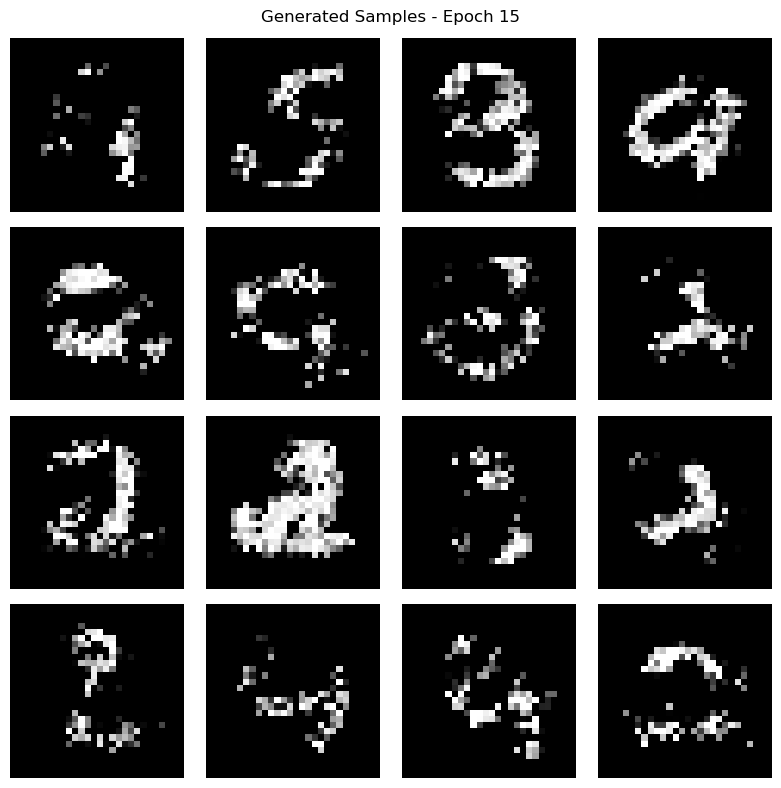

100%|██████████| 47/47 [00:02<00:00, 20.01it/s]


Epoch 16 completed. Train: loss: 0.1798, loss_cd: 0.0589, loss_clf: 0.1209, loss_reg: 0.0000, avg_energy_real: -8.8389, avg_energy_fake: -8.8978, avg_energy_rand: -2.3066
Val: loss: 0.3994, loss_cd: 0.2746, loss_clf: 0.1247, loss_reg: 0.0000, avg_energy_real: -8.8583, avg_energy_fake: -9.1329, avg_energy_rand: -2.3182(Best: 0.23548 at epoch 15)


100%|██████████| 47/47 [00:02<00:00, 20.54it/s]


Epoch 17 completed. Train: loss: 0.1727, loss_cd: 0.0570, loss_clf: 0.1157, loss_reg: 0.0000, avg_energy_real: -8.9111, avg_energy_fake: -8.9681, avg_energy_rand: -2.2954
Val: loss: 0.2792, loss_cd: 0.1598, loss_clf: 0.1194, loss_reg: 0.0000, avg_energy_real: -8.9241, avg_energy_fake: -9.0839, avg_energy_rand: -2.2878(Best: 0.23548 at epoch 15)


100%|██████████| 47/47 [00:02<00:00, 20.47it/s]


Epoch 18 completed. Train: loss: 0.1657, loss_cd: 0.0557, loss_clf: 0.1100, loss_reg: 0.0000, avg_energy_real: -8.9539, avg_energy_fake: -9.0096, avg_energy_rand: -2.2926
Val: loss: 0.2437, loss_cd: 0.1311, loss_clf: 0.1127, loss_reg: 0.0000, avg_energy_real: -9.0191, avg_energy_fake: -9.1502, avg_energy_rand: -2.2625(Best: 0.23548 at epoch 15)


100%|██████████| 47/47 [00:02<00:00, 17.96it/s]


Epoch 19 completed. Train: loss: 0.1587, loss_cd: 0.0533, loss_clf: 0.1054, loss_reg: 0.0000, avg_energy_real: -9.0220, avg_energy_fake: -9.0753, avg_energy_rand: -2.2731
Val: loss: 0.1927, loss_cd: 0.0863, loss_clf: 0.1064, loss_reg: 0.0000, avg_energy_real: -9.0815, avg_energy_fake: -9.1678, avg_energy_rand: -2.2716# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 20.43it/s]


Epoch 20 completed. Train: loss: 0.1530, loss_cd: 0.0513, loss_clf: 0.1017, loss_reg: 0.0000, avg_energy_real: -9.0842, avg_energy_fake: -9.1354, avg_energy_rand: -2.2561
Val: loss: 0.2185, loss_cd: 0.1131, loss_clf: 0.1054, loss_reg: 0.0000, avg_energy_real: -9.1009, avg_energy_fake: -9.2140, avg_energy_rand: -2.2734(Best: 0.19268 at epoch 19)


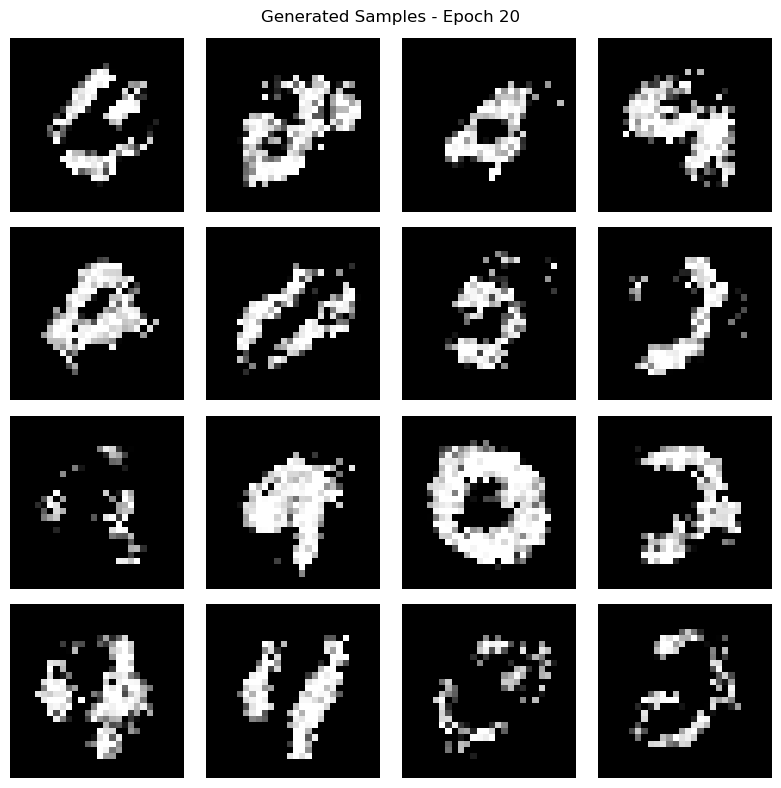

100%|██████████| 47/47 [00:02<00:00, 20.06it/s]


Epoch 21 completed. Train: loss: 0.1468, loss_cd: 0.0489, loss_clf: 0.0979, loss_reg: 0.0000, avg_energy_real: -9.1306, avg_energy_fake: -9.1795, avg_energy_rand: -2.2504
Val: loss: 0.3212, loss_cd: 0.2194, loss_clf: 0.1018, loss_reg: 0.0000, avg_energy_real: -9.1266, avg_energy_fake: -9.3460, avg_energy_rand: -2.2307(Best: 0.19268 at epoch 19)


100%|██████████| 47/47 [00:02<00:00, 20.35it/s]


Epoch 22 completed. Train: loss: 0.1429, loss_cd: 0.0484, loss_clf: 0.0945, loss_reg: 0.0000, avg_energy_real: -9.2042, avg_energy_fake: -9.2526, avg_energy_rand: -2.2407
Val: loss: 0.2311, loss_cd: 0.1345, loss_clf: 0.0965, loss_reg: 0.0000, avg_energy_real: -9.1938, avg_energy_fake: -9.3283, avg_energy_rand: -2.2359(Best: 0.19268 at epoch 19)


100%|██████████| 47/47 [00:02<00:00, 18.84it/s]


Epoch 23 completed. Train: loss: 0.1374, loss_cd: 0.0467, loss_clf: 0.0907, loss_reg: 0.0000, avg_energy_real: -9.2455, avg_energy_fake: -9.2922, avg_energy_rand: -2.2308
Val: loss: 0.2501, loss_cd: 0.1553, loss_clf: 0.0948, loss_reg: 0.0000, avg_energy_real: -9.2137, avg_energy_fake: -9.3689, avg_energy_rand: -2.2079(Best: 0.19268 at epoch 19)


100%|██████████| 47/47 [00:02<00:00, 20.35it/s]


Epoch 24 completed. Train: loss: 0.1329, loss_cd: 0.0447, loss_clf: 0.0881, loss_reg: 0.0000, avg_energy_real: -9.3111, avg_energy_fake: -9.3558, avg_energy_rand: -2.2078
Val: loss: 0.1607, loss_cd: 0.0700, loss_clf: 0.0907, loss_reg: 0.0000, avg_energy_real: -9.3309, avg_energy_fake: -9.4009, avg_energy_rand: -2.2054# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 19.84it/s]


Epoch 25 completed. Train: loss: 0.1294, loss_cd: 0.0437, loss_clf: 0.0856, loss_reg: 0.0000, avg_energy_real: -9.3676, avg_energy_fake: -9.4113, avg_energy_rand: -2.1852
Val: loss: 0.1972, loss_cd: 0.1107, loss_clf: 0.0865, loss_reg: 0.0000, avg_energy_real: -9.3828, avg_energy_fake: -9.4935, avg_energy_rand: -2.1976(Best: 0.16070 at epoch 24)


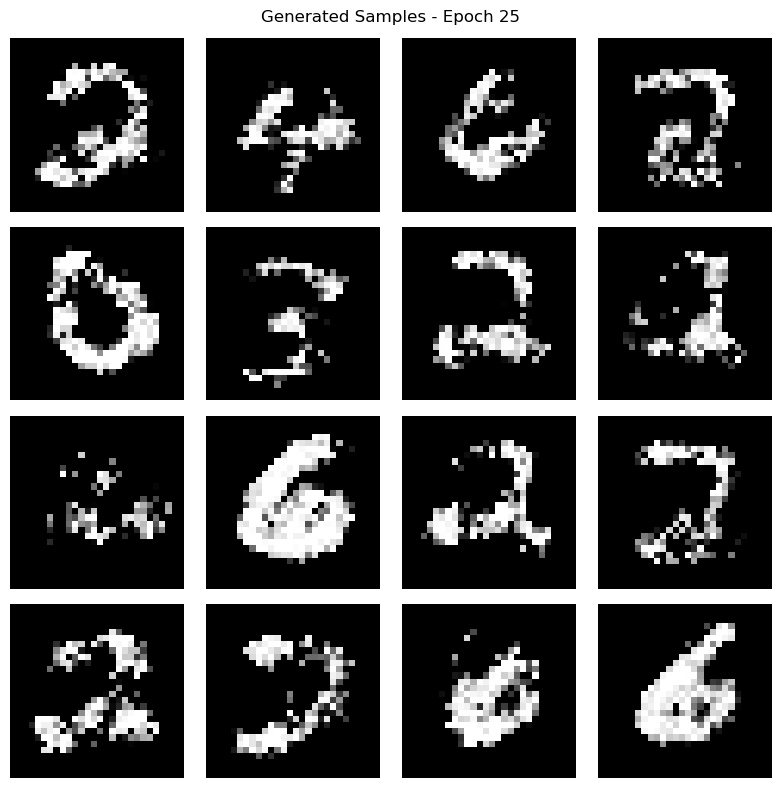

100%|██████████| 47/47 [00:02<00:00, 20.03it/s]


Epoch 26 completed. Train: loss: 0.1258, loss_cd: 0.0431, loss_clf: 0.0827, loss_reg: 0.0000, avg_energy_real: -9.4058, avg_energy_fake: -9.4489, avg_energy_rand: -2.1842
Val: loss: 0.1435, loss_cd: 0.0576, loss_clf: 0.0859, loss_reg: 0.0000, avg_energy_real: -9.4339, avg_energy_fake: -9.4915, avg_energy_rand: -2.1769# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 19.05it/s]


Epoch 27 completed. Train: loss: 0.1224, loss_cd: 0.0419, loss_clf: 0.0805, loss_reg: 0.0000, avg_energy_real: -9.4729, avg_energy_fake: -9.5148, avg_energy_rand: -2.1697
Val: loss: 0.1675, loss_cd: 0.0850, loss_clf: 0.0825, loss_reg: 0.0000, avg_energy_real: -9.4635, avg_energy_fake: -9.5484, avg_energy_rand: -2.1875(Best: 0.14348 at epoch 26)


100%|██████████| 47/47 [00:02<00:00, 17.80it/s]


Epoch 28 completed. Train: loss: 0.1183, loss_cd: 0.0402, loss_clf: 0.0781, loss_reg: 0.0000, avg_energy_real: -9.5072, avg_energy_fake: -9.5474, avg_energy_rand: -2.1470
Val: loss: 0.1834, loss_cd: 0.1011, loss_clf: 0.0823, loss_reg: 0.0000, avg_energy_real: -9.5076, avg_energy_fake: -9.6087, avg_energy_rand: -2.1136(Best: 0.14348 at epoch 26)


100%|██████████| 47/47 [00:02<00:00, 17.43it/s]


Epoch 29 completed. Train: loss: 0.1147, loss_cd: 0.0390, loss_clf: 0.0757, loss_reg: 0.0000, avg_energy_real: -9.5441, avg_energy_fake: -9.5831, avg_energy_rand: -2.1337
Val: loss: 0.2496, loss_cd: 0.1685, loss_clf: 0.0811, loss_reg: 0.0000, avg_energy_real: -9.5733, avg_energy_fake: -9.7418, avg_energy_rand: -2.1247(Best: 0.14348 at epoch 26)


100%|██████████| 47/47 [00:02<00:00, 20.60it/s]


Epoch 30 completed. Train: loss: 0.1135, loss_cd: 0.0394, loss_clf: 0.0741, loss_reg: 0.0000, avg_energy_real: -9.5945, avg_energy_fake: -9.6339, avg_energy_rand: -2.1159
Val: loss: 0.1220, loss_cd: 0.0451, loss_clf: 0.0770, loss_reg: 0.0000, avg_energy_real: -9.6634, avg_energy_fake: -9.7084, avg_energy_rand: -2.1194# NEW BEST MODEL #


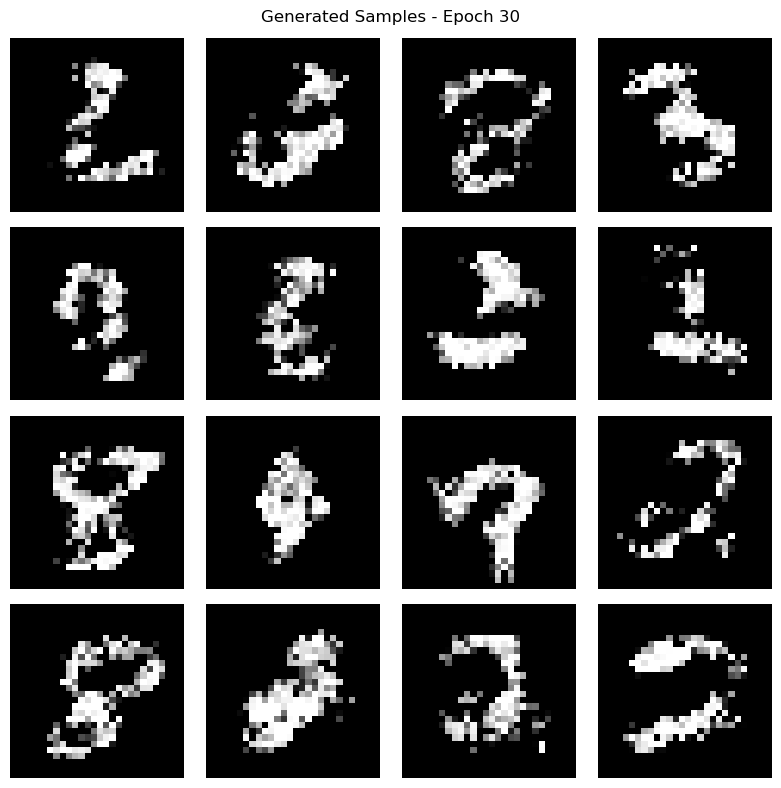

100%|██████████| 47/47 [00:02<00:00, 19.20it/s]


Epoch 31 completed. Train: loss: 0.1093, loss_cd: 0.0369, loss_clf: 0.0724, loss_reg: 0.0000, avg_energy_real: -9.6445, avg_energy_fake: -9.6814, avg_energy_rand: -2.1134
Val: loss: 0.2015, loss_cd: 0.1260, loss_clf: 0.0755, loss_reg: 0.0000, avg_energy_real: -9.7250, avg_energy_fake: -9.8509, avg_energy_rand: -2.0885(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 20.50it/s]


Epoch 32 completed. Train: loss: 0.1063, loss_cd: 0.0357, loss_clf: 0.0706, loss_reg: 0.0000, avg_energy_real: -9.6954, avg_energy_fake: -9.7310, avg_energy_rand: -2.1041
Val: loss: 0.1664, loss_cd: 0.0930, loss_clf: 0.0734, loss_reg: 0.0000, avg_energy_real: -9.7588, avg_energy_fake: -9.8517, avg_energy_rand: -2.0967(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 20.84it/s]


Epoch 33 completed. Train: loss: 0.1048, loss_cd: 0.0357, loss_clf: 0.0690, loss_reg: 0.0000, avg_energy_real: -9.7402, avg_energy_fake: -9.7760, avg_energy_rand: -2.0977
Val: loss: 0.1244, loss_cd: 0.0531, loss_clf: 0.0712, loss_reg: 0.0000, avg_energy_real: -9.7496, avg_energy_fake: -9.8027, avg_energy_rand: -2.1068(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 20.28it/s]


Epoch 34 completed. Train: loss: 0.1021, loss_cd: 0.0345, loss_clf: 0.0676, loss_reg: 0.0000, avg_energy_real: -9.7858, avg_energy_fake: -9.8203, avg_energy_rand: -2.0904
Val: loss: 0.1618, loss_cd: 0.0904, loss_clf: 0.0714, loss_reg: 0.0000, avg_energy_real: -9.7743, avg_energy_fake: -9.8647, avg_energy_rand: -2.0691(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 19.53it/s]


Epoch 35 completed. Train: loss: 0.1007, loss_cd: 0.0342, loss_clf: 0.0665, loss_reg: 0.0000, avg_energy_real: -9.8352, avg_energy_fake: -9.8694, avg_energy_rand: -2.0813
Val: loss: 0.1411, loss_cd: 0.0719, loss_clf: 0.0692, loss_reg: 0.0000, avg_energy_real: -9.8897, avg_energy_fake: -9.9616, avg_energy_rand: -2.0873(Best: 0.12202 at epoch 30)


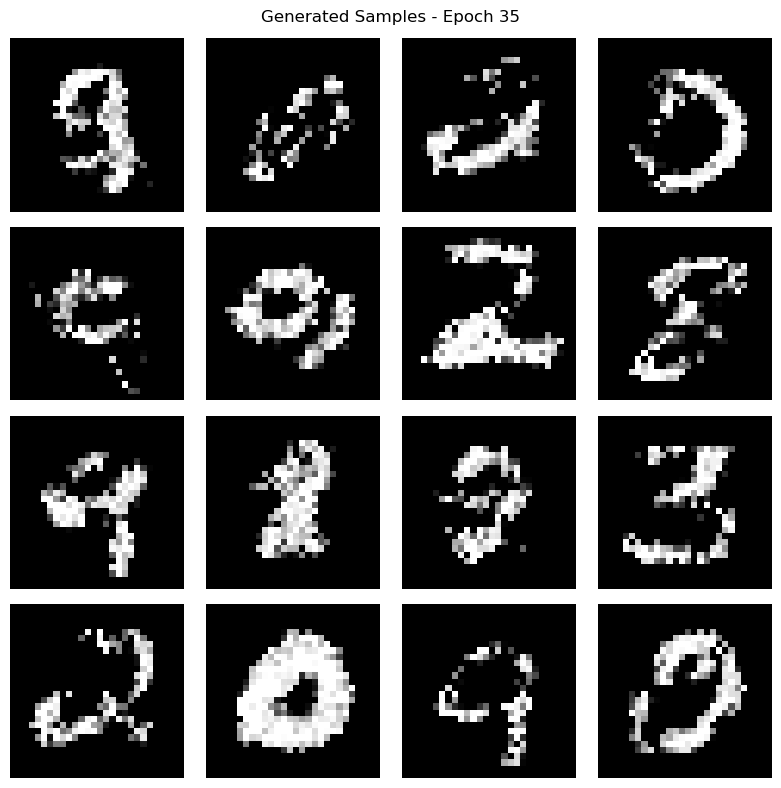

100%|██████████| 47/47 [00:02<00:00, 20.73it/s]


Epoch 36 completed. Train: loss: 0.0981, loss_cd: 0.0336, loss_clf: 0.0646, loss_reg: 0.0000, avg_energy_real: -9.8829, avg_energy_fake: -9.9164, avg_energy_rand: -2.0843
Val: loss: 0.1488, loss_cd: 0.0809, loss_clf: 0.0679, loss_reg: 0.0000, avg_energy_real: -9.9409, avg_energy_fake: -10.0219, avg_energy_rand: -2.0801(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 20.32it/s]


Epoch 37 completed. Train: loss: 0.0958, loss_cd: 0.0323, loss_clf: 0.0635, loss_reg: 0.0000, avg_energy_real: -9.9101, avg_energy_fake: -9.9424, avg_energy_rand: -2.0767
Val: loss: 0.1548, loss_cd: 0.0872, loss_clf: 0.0676, loss_reg: 0.0000, avg_energy_real: -9.9638, avg_energy_fake: -10.0510, avg_energy_rand: -2.0559(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 20.12it/s]


Epoch 38 completed. Train: loss: 0.0946, loss_cd: 0.0324, loss_clf: 0.0623, loss_reg: 0.0000, avg_energy_real: -9.9587, avg_energy_fake: -9.9910, avg_energy_rand: -2.0682
Val: loss: 0.1374, loss_cd: 0.0717, loss_clf: 0.0656, loss_reg: 0.0000, avg_energy_real: -9.9739, avg_energy_fake: -10.0457, avg_energy_rand: -2.0508(Best: 0.12202 at epoch 30)


100%|██████████| 47/47 [00:02<00:00, 19.39it/s]


Epoch 39 completed. Train: loss: 0.0926, loss_cd: 0.0313, loss_clf: 0.0614, loss_reg: 0.0000, avg_energy_real: -10.0007, avg_energy_fake: -10.0320, avg_energy_rand: -2.0452
Val: loss: 0.1094, loss_cd: 0.0447, loss_clf: 0.0647, loss_reg: 0.0000, avg_energy_real: -10.0169, avg_energy_fake: -10.0616, avg_energy_rand: -2.0772# NEW BEST MODEL #


100%|██████████| 47/47 [00:02<00:00, 20.70it/s]


Epoch 40 completed. Train: loss: 0.0908, loss_cd: 0.0306, loss_clf: 0.0602, loss_reg: 0.0000, avg_energy_real: -10.0403, avg_energy_fake: -10.0709, avg_energy_rand: -2.0479
Val: loss: 0.1791, loss_cd: 0.1153, loss_clf: 0.0637, loss_reg: 0.0000, avg_energy_real: -10.0817, avg_energy_fake: -10.1970, avg_energy_rand: -2.0451(Best: 0.10939 at epoch 39)


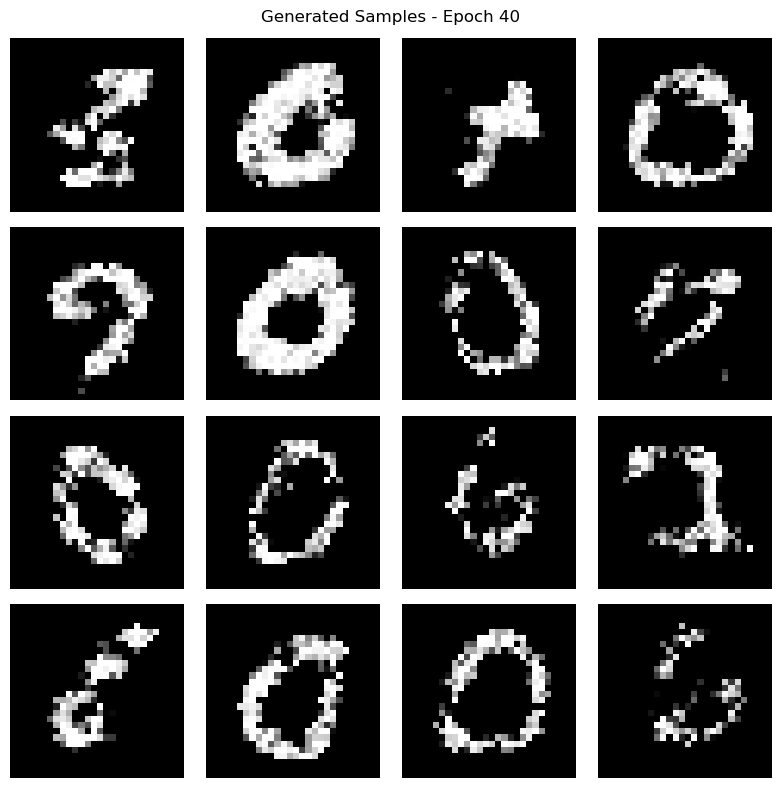

In [7]:
train_losses, val_losses = trainer.train(train_dataloader, val_dataloader, num_epochs=40)

In [7]:
model = load_model(model, model_save_path, device)
sample, sample_label = next(iter(test_dataloader))
sample = sample[:4,0]
sample_label = sample_label[:4]
noisy_sample = sample.clone().to(device)
noisy_sample.data.add_(torch.randn_like(sample, device=device), alpha=1)
denoised_sample = perform_langevin_chain(noisy_sample.clone(), model, 100, 10, 5e-3, logit_post_process_func=logits_to_energy).cpu()

Loaded model from epoch 39 with validation loss: 0.1094


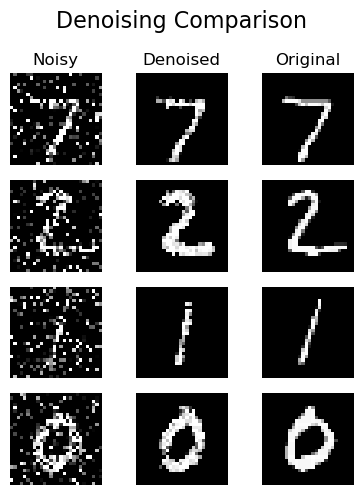

In [12]:
# Side-by-side comparison for each sample
fig, axes = plt.subplots(4, 3, figsize=(4, 5))

titles = ['Noisy', 'Denoised', 'Original']

for i in range(4):
    # Noisy
    img = noisy_sample[i].data.clip(0,1).cpu()
    if img.ndim == 3 and img.shape[0] == 1:
        img = img.squeeze(0)
    axes[i, 0].imshow(img, cmap='gray')
    axes[i, 0].axis('off')
    if i == 0:
        axes[i, 0].set_title(titles[0], fontsize=12)
    
    # Denoised
    img = denoised_sample[i].data.clip(0,1)
    if img.ndim == 3 and img.shape[0] == 1:
        img = img.squeeze(0)
    axes[i, 1].imshow(img, cmap='gray')
    axes[i, 1].axis('off')
    if i == 0:
        axes[i, 1].set_title(titles[1], fontsize=12)
    
    # Original
    img = sample[i].data.clip(0,1)
    if img.ndim == 3 and img.shape[0] == 1:
        img = img.squeeze(0)
    axes[i, 2].imshow(img, cmap='gray')
    axes[i, 2].axis('off')
    if i == 0:
        axes[i, 2].set_title(titles[2], fontsize=12)

fig.suptitle('Denoising Comparison', fontsize=16)
plt.tight_layout()
plt.show()

Generate by class

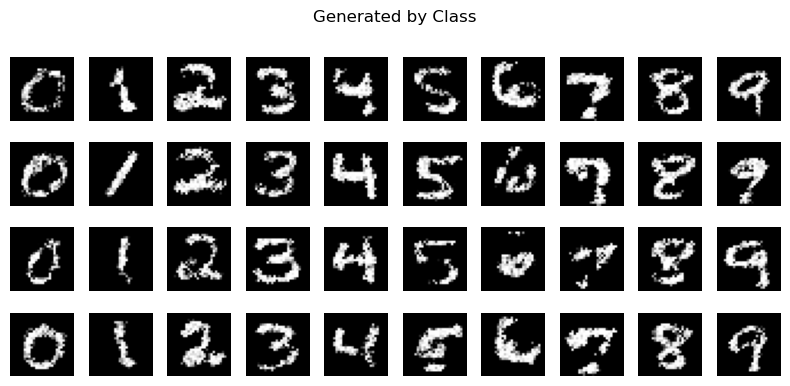

In [68]:
sampler = LangevinSampler(model, 60, 10, 5e-3, buffer, logit_post_process_func=lambda x: -x)
samples = []
for i in range(10):
    samples.append(sampler.sample(4, target_class=i)[:,0].cpu())

samples = torch.stack(samples, dim=1)
samples = samples.reshape(-1, *samples.shape[-2:])
visualize_samples(samples, 4, 10, figsize=(8, 4), title='Generated by Class')

Test model accuracy as a classifier

In [69]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, labels in test_dataloader:
        data, labels = data.to(device), labels.to(device)
        logits = model(data)
        predictions = torch.argmax(logits, dim=1)
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

Test Accuracy: 0.9774 (97.74%)
